In [1]:
cd(@__DIR__);
println(pwd());

using Pkg;
Pkg.activate(pwd());
packages = ["Glob","JLD2","Distances","ScatteredInterpolation","BenchmarkTools","Distributions","SymbolicRegression","SymbolicUtils","LaTeXStrings"]
deps = Pkg.project().dependencies;
for pkg in packages
    if pkg ∉ keys(deps)
        Pkg.add(pkg);
    end
end

/home/vfegger/projects/HTSR


  Activating project at `~/projects/HTSR`


In [2]:
using SymbolicRegression, SymbolicUtils, Plots, JLD2

inv(x) = 1.0 / x
options = Options(
    binary_operators=(+, *, ^),
    unary_operators=(inv, -, log, exp),
    batching=true,
    ncyclesperiteration=512,
    maxsize=40,
    populations=100,
    population_size=150
)

trees, complexity = load_object("Data/Case3_1024Trees.jdl")

(Node{Float64}[0.48826668925067007, 0.8569535170203804 * x2, log(1.1598185859613703 + x2), (x2 ^ 0.233665125533965) + -0.32316734523813295, 0.26950809289418043 ^ inv(x3 ^ x2), ((x3 * x2) ^ 0.16476080916810484) + -0.5859177861435009, inv(inv(x3) + (1.1789702778945812 ^ inv(x2))), (inv(x3) + (1.1071411300058027 ^ inv(x2))) ^ -1.3597282900597665, ((1.0780086298563782 ^ (x2 ^ -1.1560073753562985)) + inv(x3)) ^ -1.4380181890971542, (((1.107524062630215 ^ inv(x2)) + -0.05450731389508053) + inv(x3)) ^ -1.47538511429496  …  (inv((((log(x2) * -0.4486365232783749) + 0.29835366338157077) ^ 4.107740017820231) + ((((0.0038578998913498916 ^ x2) * -1.5325073590278435) + (x3 + 2.0365934078802406)) * inv(x3))) ^ inv(0.9879531384834342 ^ x3)) + x1, x1 + (inv((((x3 + 2.0344888146670153) + -((0.05087468366102951 ^ exp(x2)) ^ x2)) * inv(x3)) + (((log(x2) * -0.4486365232783749) + 0.29835366338157077) ^ 4.099044602938236)) ^ (1.0118977879001052 ^ x3)), (inv((((x3 + 2.0404870868500713) + -((x3 * (1.8683495380

In [3]:
dotsFile = open("Dots.sdt")
dotsContent = read(dotsFile, String)
dotsContent = replace(dotsContent, ", \r\n" => ", ")
dotsContent = replace(dotsContent, "*^" => "e")
dotsLines = split.(chop.(split(dotsContent, "\r\n"), head=1, tail=1), ", ")

nDots = length(dotsLines)
nVar = length(first(dotsLines)) - 1
nTrain = 6400
nTest = 1600

@assert nDots >= nTrain + nTest

dotsX = Array{Float64,2}(undef, nVar, nTrain)
dotsY = Vector{Float64}(undef, nTrain)

for i ∈ 1:nTrain
    dotsX[:, i] = parse.(Float64, dotsLines[i][1:end-1])
    dotsY[i] = parse(Float64, dotsLines[i][end])
end

offset = nTrain

dotsX_test = Array{Float64,2}(undef, nVar, nTest)
dotsY_test = Vector{Float64}(undef, nTest)

for i ∈ 1:nTest
    dotsX_test[:, i] .= parse.(Float64, dotsLines[i+offset][1:end-1])
    dotsY_test[i] = parse(Float64, dotsLines[i+offset][end])
end

In [4]:
dotsFile = open("Dots_eNTU.sdt")
dotsContent = read(dotsFile, String)
dotsContent = replace(dotsContent, ", \n" => ", ")
dotsContent = replace(dotsContent, "*^" => "e")
dotsLines = split.(chop.(split(dotsContent, "\n"), head=1, tail=1), ", ")

nDots = length(dotsLines)
nVar = length(first(dotsLines)) - 1

dotsX_eNTU = Array{Float64,2}(undef, nVar, nDots)
dotsY_eNTU = Vector{Float64}(undef, nDots)

for i ∈ 1:nDots
    dotsX_eNTU[:, i] = parse.(Float64, dotsLines[i][1:end-1])
    dotsY_eNTU[i] = parse(Float64, dotsLines[i][end])
end

In [5]:
for (tree, index) ∈ zip(trees, complexity)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

Complexity 1: 0.48826668925067007
Complexity 3: 0.8569535170203804 * x2
Complexity 4: log(1.1598185859613703 + x2)
Complexity 5: -0.32316734523813295 + (x2 ^ 0.233665125533965)
Complexity 6: 0.26950809289418043 ^ (1.0 / (x3 ^ x2))
Complexity 7: -0.5859177861435009 + ((x2 * x3) ^ 0.16476080916810484)
Complexity 8: 1.0 / ((1.1789702778945812 ^ (1.0 / x2)) + (1.0 / x3))
Complexity 9: ((1.1071411300058027 ^ (1.0 / x2)) + (1.0 / x3)) ^ -1.3597282900597665
Complexity 10: ((1.0 / x3) + (1.0780086298563782 ^ (x2 ^ -1.1560073753562985))) ^ -1.4380181890971542
Complexity 11: (-0.05450731389508053 + (1.0 / x3) + (1.107524062630215 ^ (1.0 / x2))) ^ -1.47538511429496
Complexity 12: 1.0 / (exp(x3 ^ -0.59842489571034) + ((-0.6467420303918245 * log(x2)) ^ 3.1089559994159095))
Complexity 13: 1.0 / ((2.907917116438036 ^ (x3 ^ -0.6326641466849534)) + ((-0.6439343618393145 * log(x2)) ^ 3.150793766219318))
Complexity 14: 1.0 / (1.0796643415361618 + (1.916350352212111 * (1.0 / x3)) + ((-0.6459387288293947 *

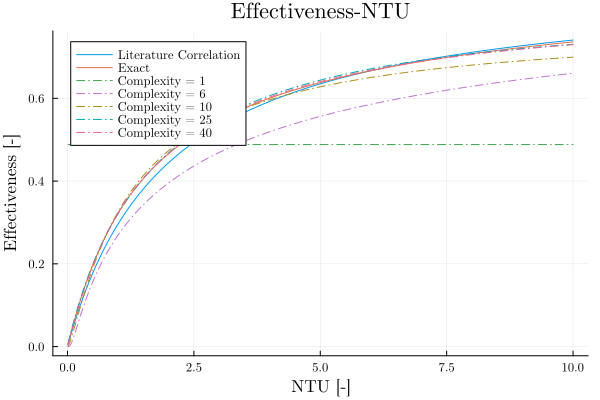

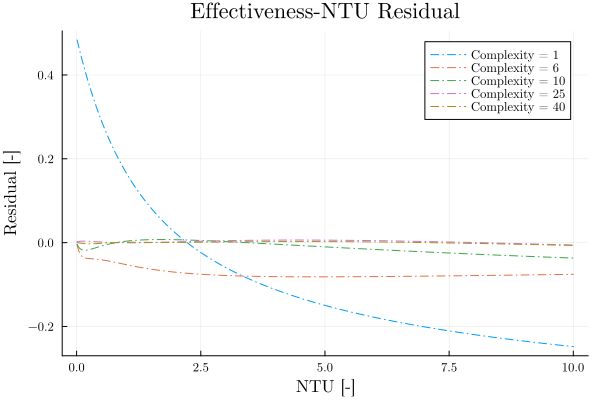

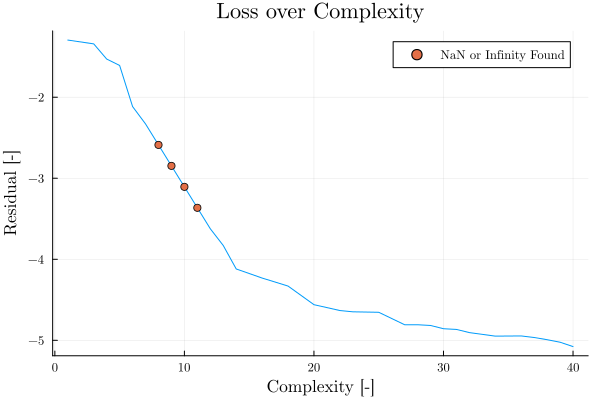

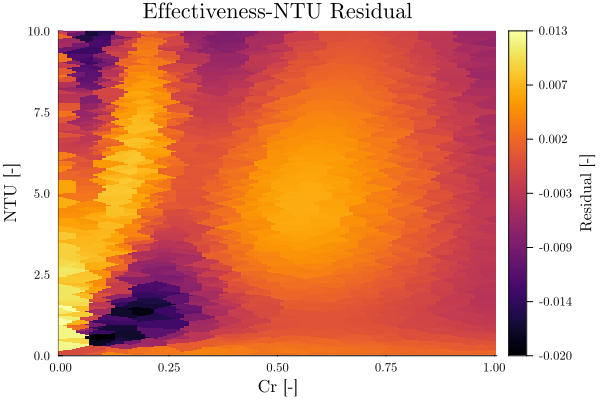

NaN or Infinity detected.
NaN or Infinity detected.
NaN or Infinity detected.
NaN or Infinity detected.
0.003586784937646562
0.01989740277715879
0.12516353036290262


"/home/vfegger/projects/HTSR/Images/eNTUCrResidual_profile.pdf"

In [27]:
using LaTeXStrings
using Distances, ScatteredInterpolation

plot_font = "Computer Modern"
default(fontfamily=plot_font)
plt = plot(title="Effectiveness-NTU", dp=1000)
plot!(dotsX_eNTU[3, :], x -> (8.0 / 9.0) * ((x / 2.0) / ((x / 2.0) + 1.0)), label="Literature Correlation", xlabel="NTU [-]", ylabel="Effectiveness [-]")
plot!(dotsX_eNTU[3, :], dotsY_eNTU[:], label="Exact", lw=1)
chosen = [1 6 10 15 25 40]
for (tree, index) ∈ zip(trees, complexity)
    result, worked = eval_tree_array(tree, dotsX_eNTU, options)
    if worked
        if index ∈ chosen
            plot!(dotsX_eNTU[3, :], result, label="Complexity = " * string(index), ls=:dashdot)
        end
    else
        println("NaN or Infinity detected.")

    end
end
display(plt)
savefig(plt, "Images/eNTU_curve.pdf")

plt = plot(title="Effectiveness-NTU Residual", dp=1000)
for (tree, index) ∈ zip(trees, complexity)
    result, worked = eval_tree_array(tree, dotsX_eNTU, options)
    if worked
        if index ∈ chosen
            plot!(dotsX_eNTU[3, :], result - dotsY_eNTU, label="Complexity = " * string(index), ls=:dashdot, xlabel="NTU [-]", ylabel="Residual [-]")
        end
    else
        println("NaN or Infinity detected.")
    end
end
display(plt)
savefig(plt, "Images/eNTUResidual_curve.pdf")

plt = plot(title="Loss over Complexity", dp=1000)
ϵ = ones(size(complexity))
miss = []
for (i, tree) ∈ enumerate(trees)
    result, worked = eval_tree_array(tree, dotsX_test, options)
    if complexity[i] == 25
        println(sum(abs, result - dotsY_test) / length(result))
        val, j = findmax(abs.(result - dotsY_test))
        println(val)
        println(abs((result[j] - dotsY_test[j]) / dotsY_test[j]))
    end
    if worked
        ϵ[i] = sum(abs2, result - dotsY_test) / length(result)
    else
        push!(miss, i)
        println("NaN or Infinity detected.")
    end
end
complexity_aux = deepcopy(complexity)
miss_complexity = [complexity_aux[i] for i in miss]
deleteat!(complexity_aux, miss)
deleteat!(ϵ, miss)
ϵ = log10.(ϵ)
miss_loss = []
for aux in miss_complexity
    index = findfirst(x -> x > aux, complexity_aux)
    aux_loss = (aux - complexity_aux[index-1]) * (ϵ[index] - ϵ[index-1]) / (complexity_aux[index] - complexity_aux[index-1]) + ϵ[index-1]
    push!(miss_loss, aux_loss)
end
plot!(complexity_aux, ϵ, label="", xlabel="Complexity [-]", ylabel="Residual [-]")
scatter!(miss_complexity, miss_loss, label="NaN or Infinity Found")
display(plt)
savefig(plt, "Images/losses_case3.pdf")

plt = plot(title="Effectiveness-NTU Residual", dp=1000, margin=(1.0, :mm),right_margin=(5.0, :mm))
s = []
for (tree, index) ∈ zip(trees, complexity)
    if index == 25
        result, worked = eval_tree_array(tree, dotsX_test, options)
        if worked
            itp = ScatteredInterpolation.interpolate(NearestNeighbor(), dotsX_test[2:3, :], result - dotsY_test, metric=WeightedEuclidean([10.0 / 11.0, 1.0 / 11.0]))
            Craxis = 0.0:0.01:1.0
            NTUaxis = 0.0:0.01:10.0
            X = repeat(Craxis, length(NTUaxis))[:]
            Y = repeat(NTUaxis', length(Craxis))[:]
            gridPoints = [X Y]'
            epsilon_val = ScatteredInterpolation.evaluate(itp, gridPoints)
            Zaxis = reshape(epsilon_val, (length(NTUaxis), length(Craxis)))'
            heatmap!(Craxis, NTUaxis, Zaxis, xlabel="Cr [-]", ylabel="NTU [-]", colorbar_title="Residual [-]")
        else
            println("NaN or Infinity detected.")
        end
    end
end
display(plt)
savefig(plt, "Images/eNTUCrResidual_profile.pdf")

In [46]:
println("Exact Trees:")
trees1, complexity1 = load_object("Data/Case1_6400Trees.jdl")
for (tree, index) ∈ zip(trees1, complexity1)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

println("Noise 1% Trees:")
trees1, complexity1 = load_object("Data/Case1_6400TreesNoise1.jdl")
for (tree, index) ∈ zip(trees1, complexity1)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

println("Noise 0.1% Trees:")
trees1, complexity1 = load_object("Data/Case1_6400TreesNoise01.jdl")
for (tree, index) ∈ zip(trees1, complexity1)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

println("Noise 0.01% Trees:")
trees1, complexity1 = load_object("Data/Case1_6400TreesNoise001.jdl")
for (tree, index) ∈ zip(trees1, complexity1)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

Exact Trees:
Complexity 1: 1086.2474056631436
Complexity 3: x1 ^ 0.56598650403332
Complexity 5: (x1 * x2) ^ 0.43467937098259396
Complexity 7: ((x2 ^ 0.6947837384227546) * x1) ^ 0.4696711391282791
Complexity 8: 1.0 / (((x2 ^ 0.6952038927277782) * x1) ^ -0.46962922412953134)
Complexity 9: (0.43956901442408647 * (x2 ^ 0.6666666879337707) * x1) ^ 0.4999999986703568
Complexity 12: -4.209348012233723e-12 + ((0.43956901442408647 * (x2 ^ 0.6666666879337707) * x1) ^ 0.4999999986703568)
Complexity 13: ((0.43956901007311466 * (x2 ^ 0.6666666902735634) * x1) ^ 0.49999999883690244) + (-4.848349000898261e-8 * x2)
Complexity 14: ((0.43956901007311466 * (x2 ^ 0.6666666902735634) * x1) ^ 0.49999999883690244) + (-4.7958588241314274e-8 * x2)
Noise 1% Trees:
Complexity 1: 1086.3239616655508
Complexity 3: x1 ^ 0.565989747006611
Complexity 5: (x1 * x2) ^ 0.4346867360690955
Complexity 7: ((x2 ^ 0.6954591848283262) * x1) ^ 0.4696000733295253
Complexity 9: (0.43637545759665 * (x2 ^ 0.6678772818975314) * x1) ^ 

In [49]:
println("Exact Trees: N = 6400")
trees2, complexity2 = load_object("Data/Case2_6400Trees.jdl")
for (tree, index) ∈ zip(trees2, complexity2)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end
println("Exact Trees: N = 12800")
trees2, complexity2 = load_object("Data/Case2_12800Trees.jdl")
for (tree, index) ∈ zip(trees2, complexity2)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end


println("Noise 1% Trees:")
trees2, complexity2 = load_object("Data/Case2_6400TreesNoise1.jdl")
for (tree, index) ∈ zip(trees2, complexity2)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

println("Noise 0.1% Trees:")
trees2, complexity2 = load_object("Data/Case2_6400TreesNoise01.jdl")
for (tree, index) ∈ zip(trees2, complexity2)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

println("Noise 0.01% Trees:")
trees2, complexity2 = load_object("Data/Case2_6400TreesNoise001.jdl")
for (tree, index) ∈ zip(trees2, complexity2)
    eqn = node_to_symbolic(tree, options)
    println("Complexity "*string(index)*": ",simplify(eqn))
end

Exact Trees: N = 6400
Complexity 1: 53.740740974395415
Complexity 3: x1 ^ 0.22743929223291376
Complexity 4: 1.0 / (x1 ^ -0.22743929223291376)
Complexity 5: 0.6665392983088878 * (x1 ^ 0.25027045812935)
Complexity 6: 0.6658020238106922 * ((1.0 / x1) ^ -0.2503332114099686)
Complexity 7: 0.1285968508489629 + ((0.18595877435547253 * x1) ^ 0.25107908713163746)
Complexity 8: (x1 ^ 0.22791217597528735) + (1.0 / (-0.11105827345216476 * x2))
Complexity 9: (-8.907793432357675 * (x2 ^ -0.27753943986859186)) + (x1 ^ 0.23071129496326057)
Complexity 10: ((0.20186408148557752 * x1) ^ 0.25051367048344747) ^ (0.9570082154311522 ^ (1.0 / x2))
Complexity 11: 0.6792065580602434 * (((1.0 / (x1 * x2)) + (1.0 / x1)) ^ -0.24984260947068673)
Complexity 12: ((0.20972686541298832 * x1) ^ 0.2500179789840118) * (0.7922176921412888 ^ (1.0 / (0.38680880830945175 + x2)))
Complexity 13: 0.6770002716595627 * (((0.9523804125387348 * (1.0 / (x1 * x2))) + (1.0 / x1)) ^ -0.24999997673075494)
Complexity 14: ((0.2100654752302